<a href="https://colab.research.google.com/github/ollihansen90/Mathe-SH-ML/blob/main/PyTorch_EMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks (CNNs)

## Setup

In [1]:
import torch # Pytorch
import torch.nn as nn # Neuronale Netze
import numpy as np # Numpy
import matplotlib.pyplot as plt # Matplotlib zum Plotten
from torch.utils.data import DataLoader # DataLoader zum Laden von Daten
from torchvision.datasets import MNIST, EMNIST # Datensätze MNIST und EMNIST
from torchvision.transforms import Compose, ToTensor, Normalize # Datenvorverarbeitung
from tqdm import tqdm # Progressbar

## Datensatz

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting /files/EMNIST/raw/gzip.zip to /files/EMNIST/raw


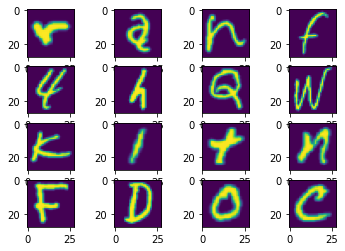

In [8]:
# Trainingsdatensatz
DS_train = EMNIST("/files/", 
                    download=True, 
                    train=True,
                    split="balanced",
                    transform=Compose([
                        ToTensor(), 
                        Normalize((0.1307,), (0.3081,))
                        ])
                    )
# Dataloader zum Laden von Trainingsdaten in den Arbeitsspeicher
dataloader_train = DataLoader(DS_train, shuffle=True, batch_size=128, num_workers=2)

# Testdatensatz
DS_test = EMNIST("/files/", 
                    download=True, 
                    train=False,
                    split="balanced",
                    transform=Compose([
                        ToTensor(), 
                        Normalize((0.1307,), (0.3081,))
                        ])
                    )
# Dataloader zum Laden von Testsdaten in den Arbeitsspeicher
dataloader_test = DataLoader(DS_test, shuffle=True, batch_size=128, num_workers=2)

# Plotte die ersten 16 Bilder
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(DS_train[i][0].squeeze().T)
plt.show()

## Eigene Faltung

In [ ]:
img = DS_train[12][0].numpy().squeeze().T
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
def falten(image, kernel):
    outputimg = np.zeros_like(image)
    zeilen, spalten = outputimg.shape
    zeilen_k, spalten_k = kernel.shape
    
    return outputimg

kernel = np.array([
    [1,1,1],
    [0,0,0],
    [-1,-1,-1]
])

#kernel = np.ones([5,5])

img_neu = falten(img, kernel)

plt.figure()
plt.imshow(img_neu)
plt.show()

## PyTorch - CNN

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.dense = nn.Linear(64, 47)
        self.act = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
    
    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.act(out)

        # Layer 2
        out = self.conv2(out)
        out = self.act(out)

        # Pooling
        out = self.pool(out).flatten(start_dim=-3)

        # Klassifikation
        out = self.dense(out)
        return out


In [29]:
# Hyperparameter
n_epochs = 10
lr = 1e-3

# Initialisiere Model
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

lossliste_train = torch.zeros(n_epochs)
accliste_train = torch.zeros(n_epochs)
lossliste_test = torch.zeros(n_epochs)
accliste_test = torch.zeros(n_epochs)
for epoch in range(n_epochs):
    print(20*"-"+" Epoch " + str(epoch) + " " + 20*"-")
    print("Start Training")

    model.train() # Versetze Model in Trainingsmodus
    losses = 0 
    accs = 0
    for data, label in tqdm(dataloader_train):
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)
        loss.backward()     # Berechne Gradienten
        optimizer.step()    # Update-Schritt

        losses += len(data)*loss.item()                         # Berechen Loss
        accs += torch.sum(torch.argmax(output, dim=-1)==label)  # Berechne Accuracy
    lossliste_train[epoch] = losses/len(DS_train)   # Speichere Loss
    accliste_train[epoch] = accs/len(DS_train)      # Speichere Accuracy
    print("Loss:", lossliste_train[epoch].item())
    print("Acc:", accliste_train[epoch].item())
    
    print("Start Testing")
    model.eval()    # Versetze Model in Evaluationsmodus
    losses = 0
    accs = 0
    confusionmat = torch.zeros([47,47])
    for data, label in tqdm(dataloader_test):
        output = model(data)
        output_argmax = torch.argmax(output, dim=-1)
        loss = criterion(output, label)
        losses += len(data)*loss.item()
        accs += torch.sum(output_argmax==label)
        for l, oarg in zip(label, output_argmax):   # Berechne Confusion-Matrix
            confusionmat[l, oarg] += 1
    lossliste_test[epoch] = losses/len(DS_test) # Speichere Loss
    accliste_test[epoch] = accs/len(DS_test)    # Speichere Accuracy
    print("Loss:", lossliste_test[epoch].item())
    print("Acc:", accliste_test[epoch].item())
    plt.figure()
    plt.imshow(confusionmat)
    plt.show()

# Plotte Losses
plt.figure()
plt.plot(lossliste_train.detach().numpy())
plt.plot(lossliste_test.detach().numpy())
plt.show()

# Plotte Accuracies
plt.figure()
plt.plot(accliste_train.detach().numpy())
plt.plot(accliste_test.detach().numpy())
plt.show()

-------------------- Epoch 0 --------------------
Start Training


  6%|▋         | 57/882 [00:10<02:34,  5.35it/s]


KeyboardInterrupt: ignored